<b><h3>Automating the Featurizer: Image Feature Extraction and Deep Learning</h3></b>

Machine learning models require semantically meaningful features to make sematically meaningful predictions. In text analysis, where a basic unit of sematic meaning (a word) is easily extractable, progress can be made very fast. Images and audio, on the other hand, are recorded as digital pixels or waveform. A single 'atom' in an image is a pixel. In audio data, it is a single measurement of waveform intensity. These contain much less sematic information than an atom - a word - of text data. Therefore, the job of feature extraction and engineeriing is much more challenging on image and audio than on text.

<b><h3>The Simplest Image Features (and Why They Don't Work)</h3></b>

What are the right features to extract from an image? The answer of course depends on what we are trying to do with those features. Let's say our task is image retrieval: we are given a pictue and asked to find similar pictures from a database of images. We need to decide how to represent each image, and how to measure the differences between them. Can we just look at the percentage of different colors in an image? Color information is probably not enough to characterize an image. Another simple idea is to measure the pixel value differences between images. First, resize the images to have the same width and height. Each image is represented by a matrix of pixel values. The matrix can be stacked into one long vector, either by row or by column. The color of each pixel (eg the RGB encoding of the color) is now a feature of the image. Finally, measure the Euclidean distance between the long pixel vectors. This would help us tell some images apart, but it is too stringent as a similarity measure. The problem is that individual pixels do not carry enough semantic information about the image. Therefore, they are bad atomic units for analysis.

<b><h3>Manual Feature Extraction: SIFT and HOG</h3></b>

Computer vision researchers figured out a better way to represent images using statistics of image patches: the Scale Invariant Feature Transform (SIFT). SIFT was originally developed for the task of object recognition, which involves not only correctly tagging the image as containing an object, but pinpointing its location in the image. The process involves analyzing the image at a pyramid of possible scales, detecting interest points that could indicate the prescence of the object, extracting features (commonly called image descriptors in computer vision) about interest points, and determining the pose of the object.

Over the years, the usage of SIFT expanded to extract features not only for interest points but across the entire image. The SIFT feature extraction procedure is very similar to another technique called the Histogram of Oriented Gradients (HOG). Both of them essentially compute histograms of gradient orientations.

<b><h4>Image Gradients</h4></b>

To do better than raw pixel values, we have to somehow "organize" the pixels into more informative units. Differences between neighboring pixels are often very useful. Pixel values usually differ at the boundary of objects, when there is a shadow, within a pattern or on a textured surface. The difference in value between neighboring pixels is called an image gradient. 

The simplest way to compute the image gradient is to separately calculate the differences along the horizontal and vertical (y) axes of the image, then compose them into a 2D vector. This involves two 1D difference operations that can be handily represented by a vector mask or filter. The mask [1,0,-1] takes the difference between the left neighbor and the right neighbor or the up-neighbor and the down-neighbor, depending on which direction we apply the mask. There are 2D gradient filters as well, but for the purpose of this example, the 1D filter suffices.

To apply a filter to an image, we perform a convolution. It involves <em>flipping the filter</em> and taking the inner product with a small patch of the image, then moving to the next patch. Convolutions are very common in signal processing.

$[a \quad b \quad c]*[1 \quad 2 \quad 3]$ = $c*1 + b*2 + a*3$

The $x$ and $y$ gradients at pixel $(i,j)$ are:

$g_x(i,j)$ = $[1 \quad 0 \; -1]$ * $[I(i – 1,j)\quad I(i,j)\quad I(i + 1,j)] = -1 * I(i – 1,j) + 1 * I(i + 1,j)$

$g_y(i,j)$ = $[1 \quad 0 \; -1]$ * $[I(i,j – 1)\quad I(i,j)\quad I(i,j + 1)] = -1 * I(i,j – 1) + 1 * I(i,j + 1)$

Together, they form the gradient:

$\nabla I(i,j)$ = $\begin{bmatrix}g_x(i,j)\\g_y(i,j)\end{bmatrix}$

A vector can be completely described by its direction and magnitude. The magnitude of the gradient is equal to the Euclidean norm of the gradient, which indicates how much the pixel values change around the pixel. The direction or orinetation of the gradient depends on the relative size of the change in the horizontal and vertical directions; it can be computed as $\theta$ = $arctan(\frac{g_y}{g_x})$.

The horizontal gradient picks out strong vertical patterns, while the vertical gradient picks out strong horizontal patterns. This might seem a little paradoxical, but it makes sense once we think about it a bit more. The horizontal (x) gradient identifies changes in the horizontal direction. A strong vertical pattern spans multiple pixels at roughly the same x position. Hence, vertical patterns result in horizontal differences in pixel values. This is what our eyes detect as well.

In [11]:
from skimage.feature import hog
from skimage import data, color, exposure
import numpy as np
import matplotlib.pyplot as plt

In [12]:
image = color.rgb2gray(data.chelsea())

In [13]:
# Compute the horizontal gradient using the centered 1D filter. This is equivalent to replacing each non-border pixel
# with the difference between right and left neighbors. The leftmost and rightmost edges have a gradient of 0.

gx = np.empty(image.shape, dtype=np.double)
gx[:,0] = 0
gx[:,-1] = 0
gx[:, 1:-1] = image[:,:-2] - image[:,2:]

# Same deal for the vertical gradient
gy = np.empty(image.shape, dtype=np.double)
gy[0,:] = 0
gy[-1,:] = 0
gy[1:-1,:] = image[:-2,:] - image[2:,:]

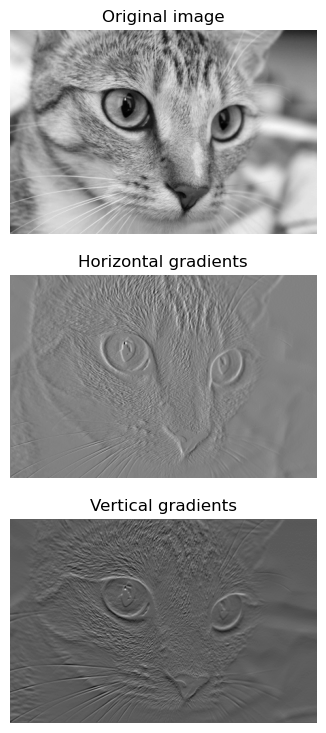

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(5,9), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image,cmap=plt.cm.gray)
ax1.set_title('Original image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(gx,cmap=plt.cm.gray)
ax2.set_title('Horizontal gradients')
ax2.set_adjustable('box')

ax3.axis('off')
ax3.imshow(gy,cmap=plt.cm.gray)
ax3.set_title('Vertical gradients')
ax3.set_adjustable('box')

<b><h4>Gradient Orientation Histograms</h4></b>

Individual image gradients can pick out minute differences in an image neighborhood. But our eyes see bigger patterns than that. The human vision system identifies contiguous patterns in a region. How exactly might we summarize vectors? A statistician would answer, "Look at the distribution!". SIFT and HOG both take this path. In particular, they compute (normalized) histograms of the gradient vectors as image features. A histogram divides data into bins and counts how many data points are in each bin; this is an (unnormalized) empirical distribution. Normalization ensures that the counts sum to 1. The mathematical language is that it has unit $l^1$ norm.

An image gradient is a vector, and vectors can be represented by two components: the orientation and magnitude. So we still need to decide how to design the historgram to take both components into account. SIFT and HOG settled on a scheme where the image gradients are binned by their orientation angle $\theta$, weighted by the magnitude of each gradient. Here is the procedure:

1. Divide $0\degree - 360\degree$ into equal-sized bins.

2. For each pixel in the neighborhood, add a weight $w$ to the bin corresponding to its orientation $\theta$. $w$ is a function of the magnitude of the gradient and other relevant information. For instance, that information might be the inverse distance of the pixel to the center of the image patch. The idea is that the weight should be large if the gradient is large, and pixels near the center of the image neighborhood matter more than pixels that are farther away.

3. Normalize the histogram


<b><h5>How many bins should there be? Should they span $0\degree$ - $360\degree$ (signed gradients) or $0\degree$ - $180\degree$ (unsigned gradients)</h5></b>

Having more bins leads to finer-grained quantization of gradient orientation, and thus retain more information about the original graidents. Having too many bins is unnecessary and could lead to overfitting to the training data. There is also the questio of whether the bins should span from $0\degree$ - $360\degree$ which would retain the sign of the gradient along the y-axis or from $0\degree$ - $180\degree$ which would not retain the sign of the vertical gradient. For HOG, it turns out 9 bins from $0\degree$ - $180\degree$ is best, whereas for SIFT 8 bins spanning from $0\degree$ - $360\degree$ is best.

<b><h5>What weight functions should be used?</h5></b>

The HOG paper compares various gradient magnitude weighting schemes: the magnitude itself, its square or square root, binarized, or clipped at the high or low ends. The plain magnitude, without adornments, performed the best in the authors' experiments. 

SIFT also uses the plain magnitude of the gradient. Additionally, it wants to avoid sudden changes in the feature descriptor resulting from small changes in the position of the image window, so it downweights gradients that come from the edges of the neighborhood using a Gaussian distance function measured from the window center. In otherwords, the gradient magnitude is multiplied by $\frac{1}{2\pi\sigma^2}e^{-∥ p- p_0∥^{2}/2σ^2}$ where p is the location of the pixel that generated the gradient, $p_0$ is the location of the center of the image neighborhood, and σ, the width of the Gaussian, is set to one-half the radius of the neighborhood.

SIFT also wants to avoid large changes in the orientation histogram resulting from small changes in the orientation of individual image gradients. So it uses an interpolation trick that spreads the weight from a single gradient into adjacent orientation bins. In particular, the root bin (the bin that the gradient is assigned to) gets a vote of 1 times the weighted magnitude. Each of the adjacent bins get a vote of 1 - $d$, where $d$ is the difference in histogram bin unit from the root bin. Overall, the vote from a single image gradient for SIFT is:

$w_{(\nabla p,b)}$ = $w_bσ||\nabla_p||$  where $\nabla_p$ is the gradient of pixel $p$ in bin $b$, $w_b$ is the interpolation weight of $b$, and σ is the Gaussian distance to the center of p.

<b><h5>How are neighborhoods defined? How should they cover the image?</h5></b>

HOG and SIFT both settled on a two-level representation of image neighborhoods: first adjacent pixels are organized into cells, and neighboring cells are then organized into blocks. An orientation histogram is computed for each cell, and the cell histogram vectors are concatenated to form the final feature descriptor for the whole block.

SIFT uses cells of 16 x 16 pixels, organized into 8 orientation bins, then grouped by blocks of 4 x 4 x 8 = 128 features for the image neighborhood. The HOG paper experimented with rectangular and circular shapes for the cells and blocks. Rectangular cells are called R-HOG blocks. The best R-HOG setting was found to be 8 x 8 pixels with 9 orientation bins each, grouped into blocks 2 x 2 cells. Circular cells are called C-HOG blocks, with variants determined by the radius of the central cell, whether or not the cells are radially divided, the width of the outer cells, etc.

No matter how neighborhoods are organized, they typically overlap to form the feature vector for the whole image. In other words, cells and blocks shift across the image horizontally and vertically, a few pixels at a time, to cover the entire image. 

The main ingredients of neighborhood architecture are multilevel orgnaization and overlaping windows that shift across the image. The same ingredients are utilized in the design of deep learning networks.

<b><h5>What kind of normalization should be done?</h5></b>

Normalization evens out the feature descriptors so that they have comparable magnitude. It is synonymous with scaling. Image features can be quite sensitive to changes in lighting and contrast. For instace , consider images of an apple under a strong spotlight versus a soft diffused light coming from a window. The image gradients would have very different magnitudes, even though the object is the same. For this reason, image featurization in computer vision usually starts with global color normalization to remove illumination and contrast variance. For SIFT and HOG, it turns out that such preprocessing is unnecessary so long as we normalize the features.

SIFT follows a normalize-threshold-normalize scheme. First, the block feature vector is normalized to unit length ($l^2$ normalization). Then, the features are clipped to a maximum value in order to get rid of extreme lighting effects such as color saturation from the camera. Finally, the clipped features are again normalized to unit length. For HOG, $l^1$ normalization is preferred.

<b></h4>SIFT Architecture</h4></b>

The SIFT pipeline requires quite a number of steps. HOG is slightly simpler but follows many of the same basic steps, such as creating a gradient historgram and normalization. 

- Starting from a region of interest in the original image, we first divide the region into a grid. Each grid cell is then further divided into subgrids. Each subgrid element contains a number of pixels, and each pixel produces a gradient. 

- Each subgrid produces a weighted gradient estimate, where the weights are chosen so that gradients outside of the subgrid element can contribute. The gradient estimates are then aggregated into an orientation histogram for the subgrid, where gradients can have weighted votes.

- The orientation histograms for each subgrid are then concatenated to form a long gradient orientation histogram for the entire grid. (if the grid is divided int 2 x 2 subgrids, then there will be 4 gradient orientation histograms to concatenate into 1.)

-  This is the feature vector for the grid, which then goes through a normalize-threshold-normalize process. First the vector is normalized to have unit norm. Then individual values are clipped to a maximum threshold. Finally, the thresholded vector is normalized again. This is the final SIFT feature descriptor for the image pitch.

In [16]:
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

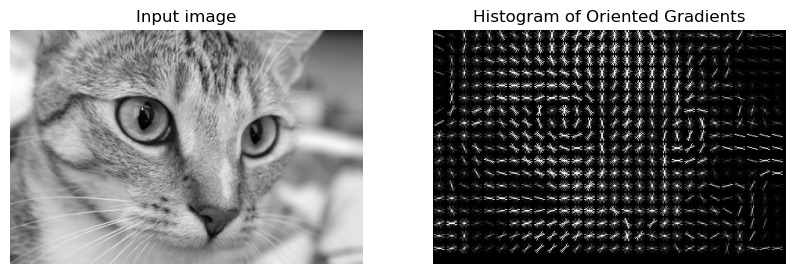

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax2.set_adjustable('box')

<b><h3>Learning Image Features with Deep Neural Networks</h3></b>

SIFT and HOG went a long way toward defining good image features. However, the latest gains in computer vision have come from a very different direction: deep neural network models. Deep learning are neural network models that contain many layers of neural networks and transformations stacked on top of each other.

On the surface, the mechanism of stacked neural networks appears very different from the image gradient histograms of SIFT and HOG. But a visualization of popular neural networks for image processing shows that the first few layers are essentially computing edge gradients and other simple patterns, much like SIFT and HOG. Subsequent layers combine local patterns into more global patterns. The end result is a feature extractor that is much more powerful than what came before. The success of deep learning methods rests upon the availability of lots of data and lots of GPU hours. Deep learning architectures can be composed of several types of layers such as fully connected, convolutional response normalization, max-pooling layers.

<b><h4>Fully Connected Layers</h4></b>

At the core of all neural networks are linear functions of the input. Logistic regression, is an example of a neural network. A fully connected neural network is simply a set of linear functions of all the input features. A linear function can be written as an inner product between the input feature vector and a weight vector plus a possible constant term. A collection of linear functions can be represented as a matrix-vector product, where the weight vector becomes a weight matrix ($W$). The mathematical definition of a fully connected layer is :

$z$ = $Wx + b$

where each row of W is a weight vector that maps the entire input vector $x$ into a single output in $z$. b is a vector of scalars representing the constant offset (or bias) for each neuron. The fully connected layer is so named because every input can be used in every output. Mathematically, this means there are no restrictions on the values in the matrix W. (A convolutional layer makes use of only a small subset of inputs for each output.) 

Fully connected layers contain the maximum possible number of parameters (# input x # output) - hence they are considered expensive. Such dense connection allow the network to detect global patterns that could involve all inputs. The last layers of neural network models are usually fully connected for this reason. The outputs are still independent from each other, conditioned on the inputs.

<b><h4>Convolutional Layers</h4></b>

In contrast to fully connected layers, a convolutional layer uses only a subset of inputs for each output. The transformation moves across the input, producing outputs using a few features at a time. For simplicity, one can use the same weights for different sets of input instead of learning new weights for each set of input.

Mathematically, the convolution operator takes two functions as input and produces one function as output. It flips one of the input functions, moves it across the other function, and outputs the total area under the multiplied curves at each point:

$(f*g)(t)$ = $\int_{-∞}^{∞} f(\tau)g(t- \tau )d(\tau)$ = $\int_{-∞}^{∞} g(\tau)f(t- \tau )d(\tau)$

This mathematical definition reveals the reason for flipping the convolution filter. Then at time $t$ = 2, for  $\tau$ = 2,  $f(2)$ gets multiplied by $g(2-2)$ which is $g(0)$ which is the value of function $g$ at a previous time of 0. Since the operator is symmetric in the inputs, it does not matter whether we flip the first input or the second input; the output is the same. So we can instead multiply $g(2)$ by $f(0)$. 

For a black box system, function $f(t)$ is the stimulus / input signal and $g(t)$ is the response function. In this way, the respons function effectively gets flipped in time, with $\tau$ = 0 always interacting with whatever stimulus is currently entering, and the tail of the response function interacting with whatever came before. The black box here is called a linear system because it doesnt do anything more crazy than scalar multiplication and summation. 

The convolution operator cleanly captures the effect of a linear system, which multiplies the incoming signal with its response function, summing over current responses to all past input. Even though $g(t)$ is the response function and $f(t)$ here, it doesnt really matter which is the response and which is the input since the convolution operation is symmetric. The output is simply a combination of both. $g(t)$ is also known as a <em>filter</em>.

Images are two-dimensional signals, so we need a 2D filter. A 2D <em>convolutional filter</em> extends the 1D case by taking the integral over two variables. Since digitial images have discrete pixels, the convolution integrals become discrete sums. Futhermore, since the number of pixels is finite, the filter functin only needs a finite number of elements. In image processing, a 2D convolution filter is also known as a kernel or a mask.

$(f*g)(i,j)$ = $\sum_{u=0}^m\sum_{v=0}^nf[u,v]g[i-u,j-v]$

When applying a convolutional filter to an image, one does not necessarily define a giant filter that covers the entire image. Rather, one formulates a small filter covering just a few pixels by a few pixels and applies the same filter accross the image, shifting over the horizontal and vertical pixel directions. Because the same filter is used across the image, one only needs to define a small set of parameters. The trade-off is that the filter can absorb information only within a smal pixel neighborhodd at a time. In other words, a convolutional neural net identifies local patterns instead of global ones. 

The convolution kernels like the full connection weights are learned from data, not predefined.


<b><h4>Gaussian filter </h4></b>

The Gaussian function forms a smooth and symmetric "mound" around zero. The filter produces a weighted average of nearby function values. When applied to an image, it has the effect of blurring nearby pixel values. The 2D Gaussian filter is defined by:

$G(x,y)$  = $\frac{1}{2\pi\sigma}e^{-\frac{x^2+y^2}{2\sigma^2}}$

where $\sigma$ is the standard deviation of the Gaussian function, which controls the width of the "mound".

In the example below, we first create a 2D Gaussian filter, then convolve it with the cat image to produce blurred cat image. The convolutional layers in real-world applications are three-dimensional. In other words, they operate on voxels(values in the array representing the 3D space of the image) from the previous layer. The first convolutional neural takes raw rgb images and learns convolution filters for a local image neighborhood across all three color channels. Subsequent layers take as input voxels across space and kernel dimensions.

In [1]:
import numpy as np

In [2]:
# First create X,Y meshgrids of size 5x5 on which we compute the Gaussian

ind = [-1., -0.5, 0., 0.5, 1.]

X, Y = np.meshgrid(ind, ind)

In [3]:
X

array([[-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ]])

In [4]:
Y

array([[-1. , -1. , -1. , -1. , -1. ],
       [-0.5, -0.5, -0.5, -0.5, -0.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.5,  0.5,  0.5,  0.5,  0.5],
       [ 1. ,  1. ,  1. ,  1. ,  1. ]])

In [25]:
# G is a simple, unnormalized Gaussian kernel where the value at (0,0) is 1.0
G = (np.exp(-(np.multiply(X,X) + np.multiply(Y,Y))/2))/(2*np.pi) # standard gaussian sigma =1.
G

array([[0.05854983, 0.0851895 , 0.09653235, 0.0851895 , 0.05854983],
       [0.0851895 , 0.12394999, 0.14045374, 0.12394999, 0.0851895 ],
       [0.09653235, 0.14045374, 0.15915494, 0.14045374, 0.09653235],
       [0.0851895 , 0.12394999, 0.14045374, 0.12394999, 0.0851895 ],
       [0.05854983, 0.0851895 , 0.09653235, 0.0851895 , 0.05854983]])

In [26]:
from skimage import data, color

cat = color.rgb2gray(data.chelsea())

In [29]:
from scipy import signal

blurred_cat = signal.convolve2d(cat,G,mode='valid')

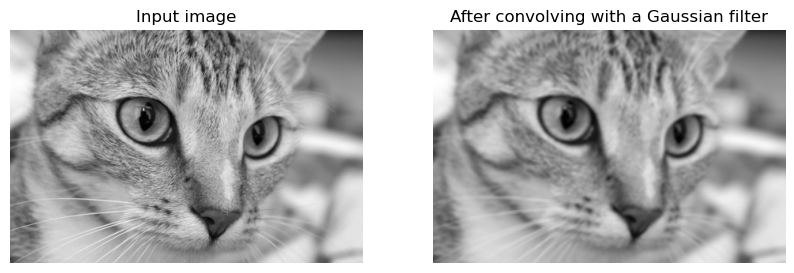

In [30]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(cat, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(blurred_cat, cmap=plt.cm.gray)
ax2.set_title('After convolving with a Gaussian filter')
ax2.set_adjustable('box')

<b><h4>Rectified Linear Unit (ReLU) Transformation</h4></b>

The output of a neural net is often passed through another nonlinear transformation, also known as an activation function. Common choices are the $tanh$ function (a smooth nonlinear function bounded between -1 and 1), the sigmoid function (a smooth nonlinear function bounded between 0 and 1) or whats known as a <em>rectified linear unit</em>. A ReLU is a simple variation of a linear function where the negative part is zeroed out. In other words, it trims away the negative values, but leaves the positive part unbounded. The range of ReLU extends from 0 to ∞.

The ReLU transformation has no effect on nonnegative functions such as the raw image or the Gaussian filter. However, a trained neural net, whether fully connected or convolutional, will likely output negative values. 

Mathematically, the ReLU function is stated as:

$ReLU(x)$ = $max(0,x)$

The tanh function is a trignometric function that smoothly increases from -1 to 1:

$tanh(x)$ = $\frac{sinh(x)}{cosh(x)} $ = $\frac{e^x –\; e^{–x}}{ e^x +\;e^{–x}}$

The sigmoid function increases smoothly from 0 to 1:

sigmoid(x) = $\frac{1}{1\;+\;e^{-x}}$

<b><h4>Response Normalization Layers</h4></b>

Normalization divides an individual output by a function of the collective total response. Hence, another way of understanding normalization is that it creates competition amongst neighbors because the strength of each output is now measured relative to its neighbors. Local response normalization breeds competition among neighboring kernels (kernel neighborhood here refers to neighboring neuron units in a layer).

$y_k$  =  $x_k\; /(c\;+\;  \alpha\sum_{l\; \epsilon \; neighborhood\;of\; k}x_l^2)^\beta$

Here, $x_k$ is the output of the $kth$ kernel, and $y_k$ is the normalized response relative to other kernels in the neighborhood. The normalization is performed separately for each output location. That is, for each output location (i,j), we normalize across the nearby convolution kernel outputs. Note that this isnt the same as normalizing over the image neighborhood or output locations. The size of the <em>kernel neighborhood</em>, c, $\alpha$, and $\beta$ are all hyperparameters that are tuned via a validation set of images.

<b><h4>Pooling Layers</h4></b>

A pooling layer combines multiple inputs into a single output. As the convolutional filter moves across an image, it generates an output for every neighborhood under its lens. Pooling forces a <em>local image neighborhood</em> to produce one value instead of many. This reduces the number of outputs in the intermediate layers of the deep learning network, which effectively reduces the probability of overfitting the network to training data.

There are multiple ways to pool inputs: averaging, summing (or computing a generalized norm), or taking the maximum value. Pooling moves across the image or intermediate output layers.